In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn
import torchvision
np.random.seed(12345)

Network Settings

In [2]:
nb_inputs  = 28*28
nb_hidden  = 100
nb_outputs = 10

time_step = 1e-3
nb_steps  = 100

batch_size = 128

dtype = torch.float
device = torch.device("cpu")

# Uncomment the line below to run on GPU
# device = torch.device("cuda:0") 

Fashion MNIST Dataset 

In [3]:
# Here we load the Dataset
root = os.path.expanduser("~/data/datasets/torch/fashion-mnist")
train_dataset = torchvision.datasets.FashionMNIST(root, train=True, transform=None, target_transform=None, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root, train=False, transform=None, target_transform=None, download=True)

(-0.5, 27.5, 27.5, -0.5)

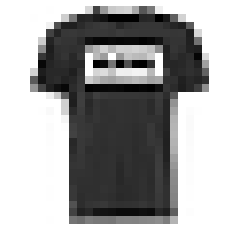

In [4]:
# Standardize data
# x_train = torch.tensor(train_dataset.train_data, device=device, dtype=dtype)
x_train = np.array(train_dataset.data, dtype=np.float)
x_train = x_train.reshape(x_train.shape[0],-1)/255
# x_test = torch.tensor(test_dataset.test_data, device=device, dtype=dtype)
x_test = np.array(test_dataset.data, dtype=np.float)
x_test = x_test.reshape(x_test.shape[0],-1)/255

# y_train = torch.tensor(train_dataset.train_labels, device=device, dtype=dtype)
# y_test  = torch.tensor(test_dataset.test_labels, device=device, dtype=dtype)
y_train = np.array(train_dataset.targets, dtype=np.int)
y_test  = np.array(test_dataset.targets, dtype=np.int)

# Here we plot one of the raw data points as an example
data_id = 1
plt.imshow(x_train[data_id].reshape(28,28), cmap=plt.cm.gray_r)
plt.axis("off")

In [5]:
# convert input data into a spiking regime 

In [5]:
def current2firing_time(x, tau=20, thr=0.2, tmax=1.0, epsilon=1e-7):
    """ Computes first firing time latency for a current input x assuming the charge time of a current based LIF neuron.

    Args:
    x -- The "current" values

    Keyword args:
    tau -- The membrane time constant of the LIF neuron to be charged
    thr -- The firing threshold value 
    tmax -- The maximum time returned 
    epsilon -- A generic (small) epsilon > 0

    Returns:
    Time to first spike for each "current" x
    """
    idx = x<thr
    x = np.clip(x,thr+epsilon,1e9)
    T = tau*np.log(x/(x-thr))
    T[idx] = tmax
    return T
 

def sparse_data_generator(X, y, batch_size, nb_steps, nb_units, shuffle=True ):
    """ This generator takes datasets in analog format and generates spiking network input as sparse tensors. 

    Args:
        X: The data ( sample x event x 2 ) the last dim holds (time,neuron) tuples
        y: The labels
    """

    labels_ = np.array(y,dtype=np.int)
    number_of_batches = len(X)//batch_size
    sample_index = np.arange(len(X))

    # compute discrete firing times
    tau_eff = 20e-3/time_step
    firing_times = np.array(current2firing_time(X, tau=tau_eff, tmax=nb_steps), dtype=np.int)
    unit_numbers = np.arange(nb_units)

    if shuffle:
        np.random.shuffle(sample_index)

    total_batch_count = 0
    counter = 0
    while counter<number_of_batches:
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]

        coo = [ [] for i in range(3) ]
        for bc,idx in enumerate(batch_index):
            c = firing_times[idx]<nb_steps
            times, units = firing_times[idx][c], unit_numbers[c]

            batch = [bc for _ in range(len(times))]
            coo[0].extend(batch)
            coo[1].extend(times)
            coo[2].extend(units)

        i = torch.LongTensor(coo).to(device)
        v = torch.FloatTensor(np.ones(len(coo[0]))).to(device)
    
        X_batch = torch.sparse.FloatTensor(i, v, torch.Size([batch_size,nb_steps,nb_units])).to(device)
        y_batch = torch.tensor(labels_[batch_index],device=device)

        yield X_batch.to(device=device), y_batch.to(device=device)

        counter += 1
        
def get_mini_batch(x_data, y_data, shuffle=False):
    for ret in sparse_data_generator(x_data, y_data, batch_size, nb_steps, nb_inputs, shuffle=shuffle):
        return ret 

Temporal Constants for spiking neural network

In [7]:
tau_mem = 10e-3
tau_syn = 5e-3
tau_eps = 10e-3
alpha   = float(np.exp(-time_step/tau_syn))
eps     = float(np.exp(-time_step/tau_eps))
beta    = float(np.exp(-time_step/tau_mem))

In [8]:
def spike_fn(x):
    out = torch.zeros_like(x)
    out[x > 0] = 1.0
    return out

def plot_voltage_traces(mem, spk=None, dim=(3,5), spike_height=5):
    gs=GridSpec(*dim)
    if spk is not None:
        dat = (mem+spike_height*spk).detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i],sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")
        
def plot_single_traces(trace, spk=None, spike_height=5, ax=None, title=None):
    if ax is None:
        ax = plt.gca()
    if title is not None:
        ax.set_title(title)
    if spk is not None:
        dat = (trace+spike_height*spk).detach().cpu().numpy()
    else:
        dat = trace.detach().cpu().numpy()
    ax.plot(dat[0])

def run_snn(inputs):
    h1 = torch.einsum("abc,cd->abd", (inputs, w1))
    syn = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)

    mem_rec = [mem]
    spk_rec = [mem]

    # Compute hidden layer activity
    for t in range(nb_steps):
        mthr = mem-1.0
        out = spike_fn(mthr)
        rst = torch.zeros_like(mem)
        c   = (mthr > 0)
        rst[c] = torch.ones_like(mem)[c]

        new_syn = alpha*syn +h1[:,t]
        new_mem = beta*mem +syn -rst

        mem = new_mem
        syn = new_syn

        mem_rec.append(mem)
        spk_rec.append(out)

    mem_rec = torch.stack(mem_rec,dim=1)
    spk_rec = torch.stack(spk_rec,dim=1)

    # Readout layer
    h2 = torch.einsum("abc,cd->abd", (spk_rec, w2))
    syn = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    mem = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    spk_o_rec = [out]
    mem_o_rec = [mem]
    for t in range(nb_steps):
        mthr = mem-1.0
        out = spike_fn(mthr)
        rst = torch.zeros_like(mem)
        c   = (mthr > 0)
        rst[c] = torch.ones_like(mem)[c]
        
        new_syn = alpha*syn +h2[:,t]
        new_mem = beta*mem +syn -rst
        
        mem = new_mem
        syn = new_syn
        
        spk_o_rec.append(out)
        mem_o_rec.append(mem)

    spk_o_rec = torch.stack(spk_o_rec,dim=1)
    mem_o_rec = torch.stack(mem_o_rec, dim=1)
    out_recs = [mem_o_rec, spk_o_rec]
    other_recs = [mem_rec, spk_rec]
    return out_recs, other_recs

In [9]:
# init weights for SNN
weight_scale = 7*(1.0-beta) # this should give us some spikes to begin with

w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

print("init done")

init done


In [10]:
x_batch, y_batch = get_mini_batch(x_test, y_test)
output_layer, hidden_layer = run_snn(x_batch.to_dense())
mem_rec, spk_rec = hidden_layer

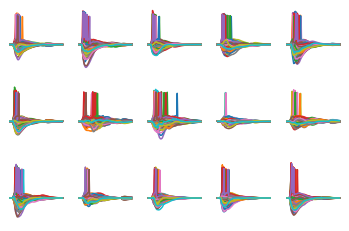

In [11]:
plot_voltage_traces(mem_rec, spk_rec)
#plot_voltage_traces(*output_layer)

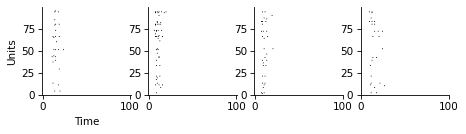

In [12]:
# Let's plot the hiddden layer spiking activity for some input stimuli

nb_plt = 4
gs = GridSpec(1,nb_plt)
fig= plt.figure(figsize=(7,3),dpi=75)
for i in range(nb_plt):
    plt.subplot(gs[i])
    plt.imshow(spk_rec[i].detach().cpu().numpy().T,cmap=plt.cm.gray_r, origin="lower" )
    if i==0:
        plt.xlabel("Time")
        plt.ylabel("Units")

    sns.despine()

In [21]:
def train(x_data, y_data, lr=2e-3, nb_epochs=10):
    params = [w1,w2]
    optimizer = torch.optim.Adam(params, lr=lr, betas=(0.9,0.999))

    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()
    
    loss_hist = []
    for e in range(nb_epochs):
        local_loss = []
        for x_local, y_local in sparse_data_generator(x_data, y_data, batch_size, nb_steps, nb_inputs):
            output,_ = run_snn(x_local.to_dense())
            m,_=torch.max(output,1)
            log_p_y = log_softmax_fn(m)
            loss_val = loss_fn(log_p_y, y_local)

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            local_loss.append(loss_val.item())
        mean_loss = np.mean(local_loss)
        print("Epoch %i: loss=%.5f"%(e+1,mean_loss))
        loss_hist.append(mean_loss)
        
    return loss_hist
        
        
def compute_classification_accuracy(x_data, y_data):
    """ Computes classification accuracy on supplied data in batches. """
    accs = []
    for x_local, y_local in sparse_data_generator(x_data, y_data, batch_size, nb_steps, nb_inputs, shuffle=False):
        output,_ = run_snn(x_local.to_dense())
        m,_= torch.max(output,1) # max over time
        _,am=torch.max(m,1)      # argmax over output units
        tmp = np.mean((y_local==am).detach().cpu().numpy()) # compare to labels
        accs.append(tmp)
    return np.mean(accs)

### Supervised learning with the true gradient

In [13]:
def get_eltr(hidden_rec, x_data, out_rec):
    # HIDDEN LAYER
    presyn = torch.zeros((batch_size,nb_inputs), device=device, dtype=dtype)
    eltr = torch.zeros((batch_size, nb_hidden, nb_inputs), device=device, dtype=dtype)
    surr = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
    surrgradscale = 5
    surr_rec = [surr]
    eltr_rec = [eltr]
    mem_rec = hidden_rec[0]
    for t in range(nb_steps):
        c = (mem_rec[:, t] - 1.0 > 0)
        surr = 1/(surrgradscale * torch.abs(mem_rec[:, t] - 1.0) + 1.0)**2
        surr = torch.clamp(surr, min=0.0, max = 1.0)
        
        new_presyn = alpha*presyn +  x_data[:,t]
        new_eltr = beta*eltr + torch.einsum("ab,ac->abc", (surr, new_presyn))

        presyn = new_presyn
        eltr = new_eltr

        eltr_rec.append(eltr)
        surr_rec.append(surr)

    eltr_rec = torch.stack(eltr_rec,dim=1)
    surr_rec = torch.stack(surr_rec,dim=1)

    # READOUT LAYER
    presyn_o = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
    eltr_o = torch.zeros((batch_size, nb_outputs, nb_hidden), device=device, dtype=dtype)
    surr_o = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)

    surr_o_rec = [surr_o]
    eltr_o_rec = [eltr_o]
    mem_rec = out_rec[0]
    spikes = hidden_rec[1]
    for t in range(nb_steps):
        c = (mem_rec[:, t] - 1.0 > 0)
        surr_o = 1/(surrgradscale * torch.abs(mem_rec[:, t] - 1.0) + 1.0)**2
        surr_o = torch.clamp(surr_o, min=0.0, max = 1.0)
        
        new_presyn_o = alpha*presyn_o +  spikes[:,t]
        new_eltr_o = beta*eltr_o + torch.einsum("ab,ac->abc", (surr_o, new_presyn_o))

        presyn_o = new_presyn_o
        eltr_o = new_eltr_o

        eltr_o_rec.append(eltr_o)
        surr_o_rec.append(surr_o)

    eltr_o_rec = torch.stack(eltr_o_rec,dim=1)
    surr_o_rec = torch.stack(surr_o_rec,dim=1)

    return eltr_rec, eltr_o_rec, surr_rec, surr_o_rec

def error(spk_rec, labels, target_window = (1,120), dflt_spk = 35):
    start, end = target_window

    # test if spikes are where they shouldnt be
    mask = torch.ones_like(spk_rec, dtype=bool, requires_grad=False) # (n_batches, time, n_outputs)
    for i, l in enumerate(labels):
        mask[i, start:end, l] = False

    outside_spk = -spk_rec * mask

    # there is no spike but there should be
    inside_spk = torch.zeros_like(spk_rec, requires_grad=False)
    inside_mask = torch.zeros(batch_size, dtype=bool, requires_grad=False)

    for o in range(nb_outputs):
        inside_mask[labels == o] = torch.sum(spk_rec[labels == o,start:end, o], dim=1, dtype=bool)

    inside_spk[inside_mask, dflt_spk, labels[inside_mask]] = 1

    err_spk = inside_spk + outside_spk


    # convolution
    err = torch.zeros_like(spk_rec[:,0,:])
    err_rec = [err]
    for t in range(nb_steps):
        new_err = eps * err + err_spk[:,t]
        err = new_err
        err_rec.append(err)

    err_rec = torch.stack(err_rec,dim=1)
    return err_rec

In [14]:
out_rec, hidden_rec = run_snn(x_batch.to_dense())
eltr_rec, eltr_o_rec, surr_rec, surr_o_rec = get_eltr(hidden_rec, x_batch.to_dense(), out_rec)

# grad and error
err_o = error(out_rec[1], y_batch)
grad_o = torch.mean(torch.einsum("abdc, abd->acd", (eltr_o_rec, err_o)), dim=0)

err = torch.einsum("abd,dc->abc", (err_o, w2.T))
grad = torch.mean(torch.einsum("abdc, abd->acd", (eltr_rec, err)), dim=0)

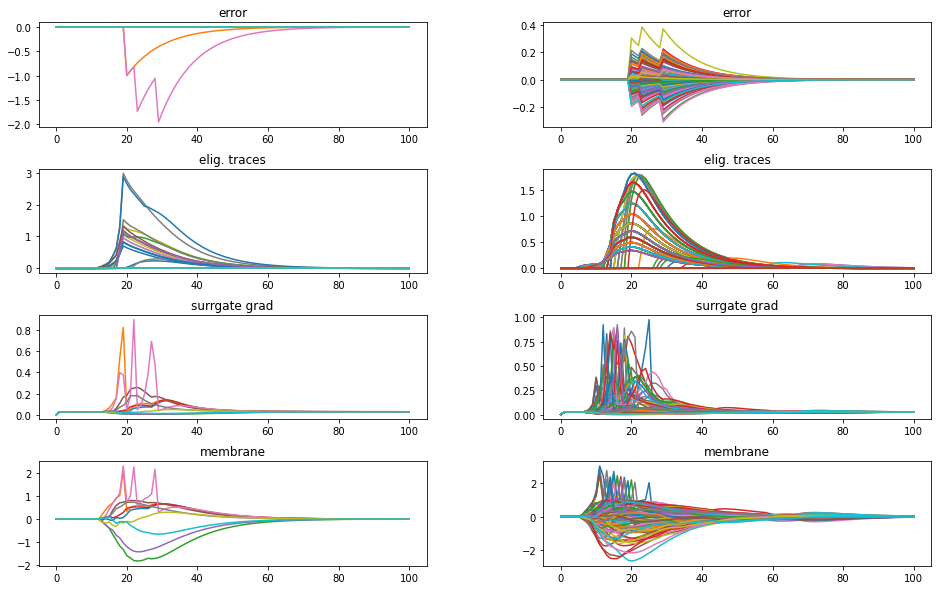

In [93]:
out_rec, hidden_rec = run_snn(x_batch.to_dense())
# eltr
eltr_rec, eltr_o_rec, surr_rec, surr_o_rec = get_eltr(hidden_rec, x_batch.to_dense(), out_rec)

# error
err_o = error(out_rec[1], y_batch)
err = torch.einsum("abd,dc->abc", (err_o, w2.T))

fig, axes = plt.subplots(4,2, figsize=(16,10))
idx = 0
plt.subplots_adjust(wspace=0.3, hspace=0.4)
plot_single_traces(err_o[idx:], ax=axes[0,0], title="error")
plot_single_traces(eltr_o_rec[idx:, :,1], ax=axes[1,0], title="elig. traces")
plot_single_traces(surr_o_rec[idx:], ax=axes[2,0], title="surrgate grad")
plot_single_traces(out_rec[0][idx:], out_rec[1][idx:], ax=axes[3,0], spike_height=2, title="membrane")

plot_single_traces(err[idx:], ax=axes[0,1], title="error")
plot_single_traces(eltr_rec[idx:,:,3], ax=axes[1,1], title="elig. traces")
plot_single_traces(surr_rec[idx:], ax=axes[2,1], title="surrgate grad")
plot_single_traces(hidden_rec[0][idx:], hidden_rec[1][idx:], ax=axes[3,1], spike_height=2, title="membrane")

In [107]:
def train(x_data, y_data, lr=2e-3, nb_epochs=2):
    params = [w1,w2]
    optimizer = torch.optim.SGD(params, lr=8e-4)

    totalloss = []
    for e in range(nb_epochs):
        loss = []
        for x_local, y_local in sparse_data_generator(x_data, y_data, batch_size, nb_steps, nb_inputs):
            out_rec, hidden_rec = run_snn(x_local.to_dense())

            # eltr
            eltr_rec, eltr_o_rec, surr_rec, surr_o_rec = get_eltr(hidden_rec, x_local.to_dense(), out_rec)

            # grad and error
            err_o = error(out_rec[1], y_local)
            grad_o = torch.mean(torch.einsum("abdc, abd->acd", (eltr_o_rec, err_o)), dim=0)

            err = torch.einsum("abd,dc->abc", (err_o, w2.T))
            grad = torch.mean(torch.einsum("abdc, abd->acd", (eltr_rec, err)), dim=0)

            # calculate gradients
            optimizer.zero_grad()
            w2.grad = -grad_o
            w1.grad = -grad
            optimizer.step()
            loss.append(torch.sum(torch.abs(err_o)))
        totalloss.append(np.mean(loss))
        print("%s/40: av. loss = %s" % (e, torch.sum(torch.abs(err_o))))

    return totalloss

In [108]:
np.random.seed(12345)
# The following lines will reinitialize the weights
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))
print("init done")

loss = train(x_test, y_test)

init done
0/40: av. loss = tensor(10.5019)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/simi/anaconda3/envs/spytorch/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-108-3b17a26c9d41>", line 7, in <module>
    loss = train(x_test, y_test)
  File "<ipython-input-107-22ea55fb433f>", line 19, in train
    grad = torch.mean(torch.einsum("abdc, abd->acd", (eltr_rec, err)), dim=0)
  File "/home/simi/anaconda3/envs/spytorch/lib/python3.7/site-packages/torch/functional.py", line 292, in einsum
    return _VF.einsum(equation, operands)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/simi/anaconda3/envs/spytorch/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During handling 

TypeError: object of type 'NoneType' has no len()

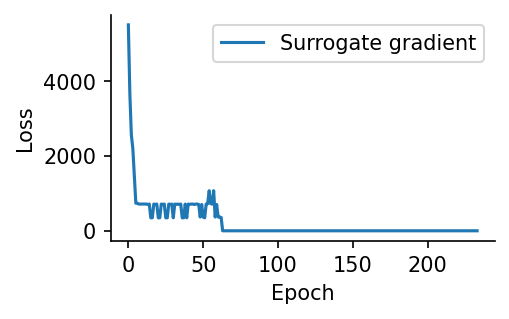

In [48]:
plt.figure(figsize=(3.3,2),dpi=150)
#plt.plot(loss_hist_true_grad, label="True gradient")
plt.plot(totalloss, label="Surrogate gradient")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
sns.despine()

In [49]:
output,other_recordings = run_snn(x_data)
mem_rec, spk_rec = other_recordings

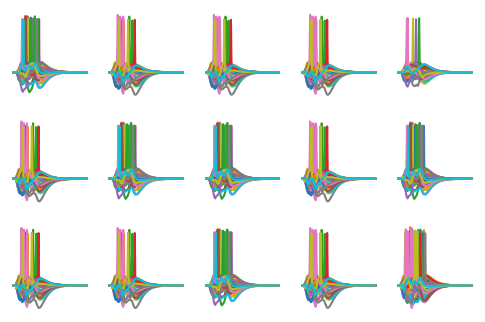

In [50]:
fig=plt.figure(dpi=100)
plot_voltage_traces(mem_rec, spk_rec)

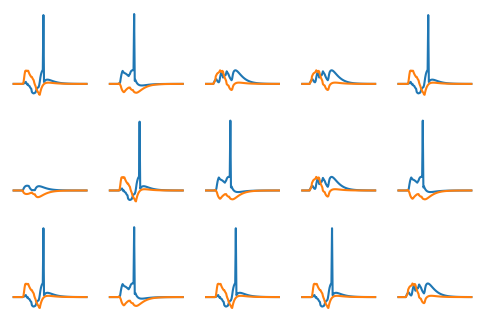

In [51]:
idx = 15
fig=plt.figure(dpi=100)
plot_voltage_traces(output[0][idx:], output[1][idx:])

In [52]:
y_data[idx:idx + 15].reshape((3,5))

tensor([[1, 1, 0, 0, 1],
        [0, 1, 1, 0, 1],
        [1, 1, 1, 1, 0]])